<a href="https://colab.research.google.com/github/Malvi-M/Semantic-Image-Segmentation-on-Urban-Streets/blob/main/VGG_FCN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Loading and Preprocessing**

Image segmentation can be interpreted as a classification problem, where the task is to classify each pixel of the image into a particular class. To build an end-to-end pixel-to-pixel segmentation network, our model must be capable of extracting rich spatial information from the images. A typical CNN used for classification takes an image as input, passes it through a series of convolutional and pooling layers and uses fully-connected layers in the end to output a fixed length vector, thus discarding all the spatial information from the original image. For building our model, we have used the `cityscapes-image-pairs` dataset, containing 2975 images which are used for training and 500 images for validating the performance of our model.

**Importing the required libraries**



*   Numpy - for linear algebra
*   os - for receiving information about files
*   matplotlib - for visualizing
*   PIL and CV2 - for image loading and editing
*   scikit-learn KMeans - for color clustering
*   random - for generating random numbers and choices
*   keras - a high level interface to tensorflow (for neural networks)


In [ ]:
import numpy as np 
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate, Add, Activation
from keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
import keras.metrics

#### **Initialize Variables**

In [ ]:
train_folder="/content/drive/MyDrive/AI_Project/Image_Pairs/cityscapes_data/train"
valid_folder="/content/drive/MyDrive/AI_Project/Image_Pairs/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

## **Helper Functions**


---


For preprocessing the dataset and defining the model, we have defined several helper functions -


* `LoadImage` - Loads a single image and its corresponding segmentation map, also allows simple Data Augmentation options such as flipping and rotating 
    * **Arguements** :
        * `name` - Name of the image file
        * `path` - Path to the image directory
        * `rotation` - Angle by which the image will rotate for Data Augmentation
        * `flip` - True/False
        * `size` - size of image
    * **Returns** - A tuple of 2 numpy arrays (image and segmentation map)



---


* `ColorToClass` - Converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation used for training our model
    * **Arguements** :
        * `seg` - Segmentation mask after clustering (width, height, 3) **(RGB)**
    * **Returns** - Categorical segmentation map (width, height, classes) 



---


* `LayersToRGBImage` - Converts the layer representation (categorical arrays) to a color representation for visualization 
    * **Arguements** :
        * `img` - Categorical segmented map (height, width, 13)
    * **Returns** - Colored segmentation map (width, height, 3) **(RGB)**


---


* `DataGenerator` - creates batches of e.g. 10 raw-segmented image pairs at a time, also uses image augmentation and randomly flips and rotates the images to increase the effective size of the dataset and returns data in form of batches  
    * **Arguements** :
        * `path` - location or path of the image directory
        * `batch_size` - size of each batch
        * `maxangle` -  angle to rotate image
    * **Returns** - Tuple of `batch_size` number of images and segmentation maps


---







* `fcn` - Creates the FCN model
    * **Arguements** :
        * `vgg` - VGG16 pretrained model
        * `classes` - Number of categories or unique pixel values (13)
        * `fcn8` - Set True to use FCN-8s model
        * `fcn16` - Set True to use FCN-16s model
    * **Returns** - FCN model
    * **Note** - If both `fcn8` and `fcn16` arguements are set to False, it returns FCN-32s model by default




---










#### **LoadImage**

In [ ]:
def LoadImage(name, path=train_folder,
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 256)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

        #seg = np.round(seg/255.0)
    
    return img/255, seg/255

#### **Color Clustering**

In [ ]:
files =os.listdir(train_folder)[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(n_clusters=13, random_state=32)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=32, tol=0.0001, verbose=0)

#### **ColorsToClass**

In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

#### **LayersToRGBImage**

In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

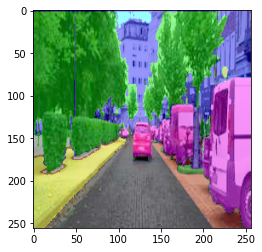

In [ ]:
img, seg = LoadImage("111.jpg")                     ## img = (200, 256, 3) && seg = (200, 256, 3)
seg2 = ColorsToClass(seg)                           ## seg2 = (200, 256, 13)
seg2 = LayersToRGBImage(seg2)                       ## seg2 = (200, 256, 3)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)     ## total = (200, 256, 3)
plot.imshow(total[:,:,:])
plot.show()

#### **DataGenerator**

In [ ]:
def DataGenerator(path=train_folder, batch_size=10, maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)

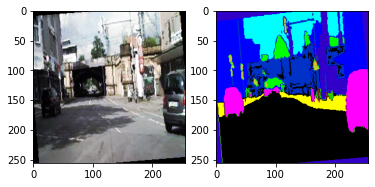

In [ ]:
gen = DataGenerator()
imgs, segs = next(gen)
# imgs.shape, segs.shape
plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()


## **Segmentation model : VGG + FCN (Transfer Learning)**




![Segmentation Architecture](https://csdl-images.computer.org/trans/tp/2017/04/figures/shelh3-2572683.gif)

The architecture used in this notebook is shown in the figure above. The segmentation operation performed by the network can be divided into two parts -

* **Downsampling operation -** This part is simple. Our image is propagated through a series of convolutional and pooling layers to extract the spatial information. For this I have used the `VGG-16` architecture initialized with weights pretrained on the Imagenet dataset. The final fully connected layers of the network are discarded and two new convolutional layers `conv6` and `conv7` are added in their place. While training, the entire model is trained, thus fine-tuning the pretrained weights on our dataset.

* **Upsampling operation -** This generates the classification map from the feature map produced in the Downsampling operation. The operation is also referred as deconvolution or fractionally strided convolution operation, i.e. features of smaller spatial resolution are mapped to larger spatial resolution. Depending upon the upsampling strategy, our network can be of three types as shown in the figure -

    * **FCN-32s** - Directly produces segmentation map from `conv7` layer by using transpose convolution with stride 32
    * **FCN-16s** - Add 1 x 1 convolution on `pool4` and fuse it with 2X upsampled `conv7`. The segmentation map is then produced by using a transpose convolution on the result with stride 16 
    * **FCN-8s** - Add 1 x 1 convolution on `pool3` and fuse it with 2X upsampled fused predictions of `conv7` and `pool4`. The segmentation map is then produced by using a transpose convolution on the result with stride 8

In [ ]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model = fcn(vgg, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

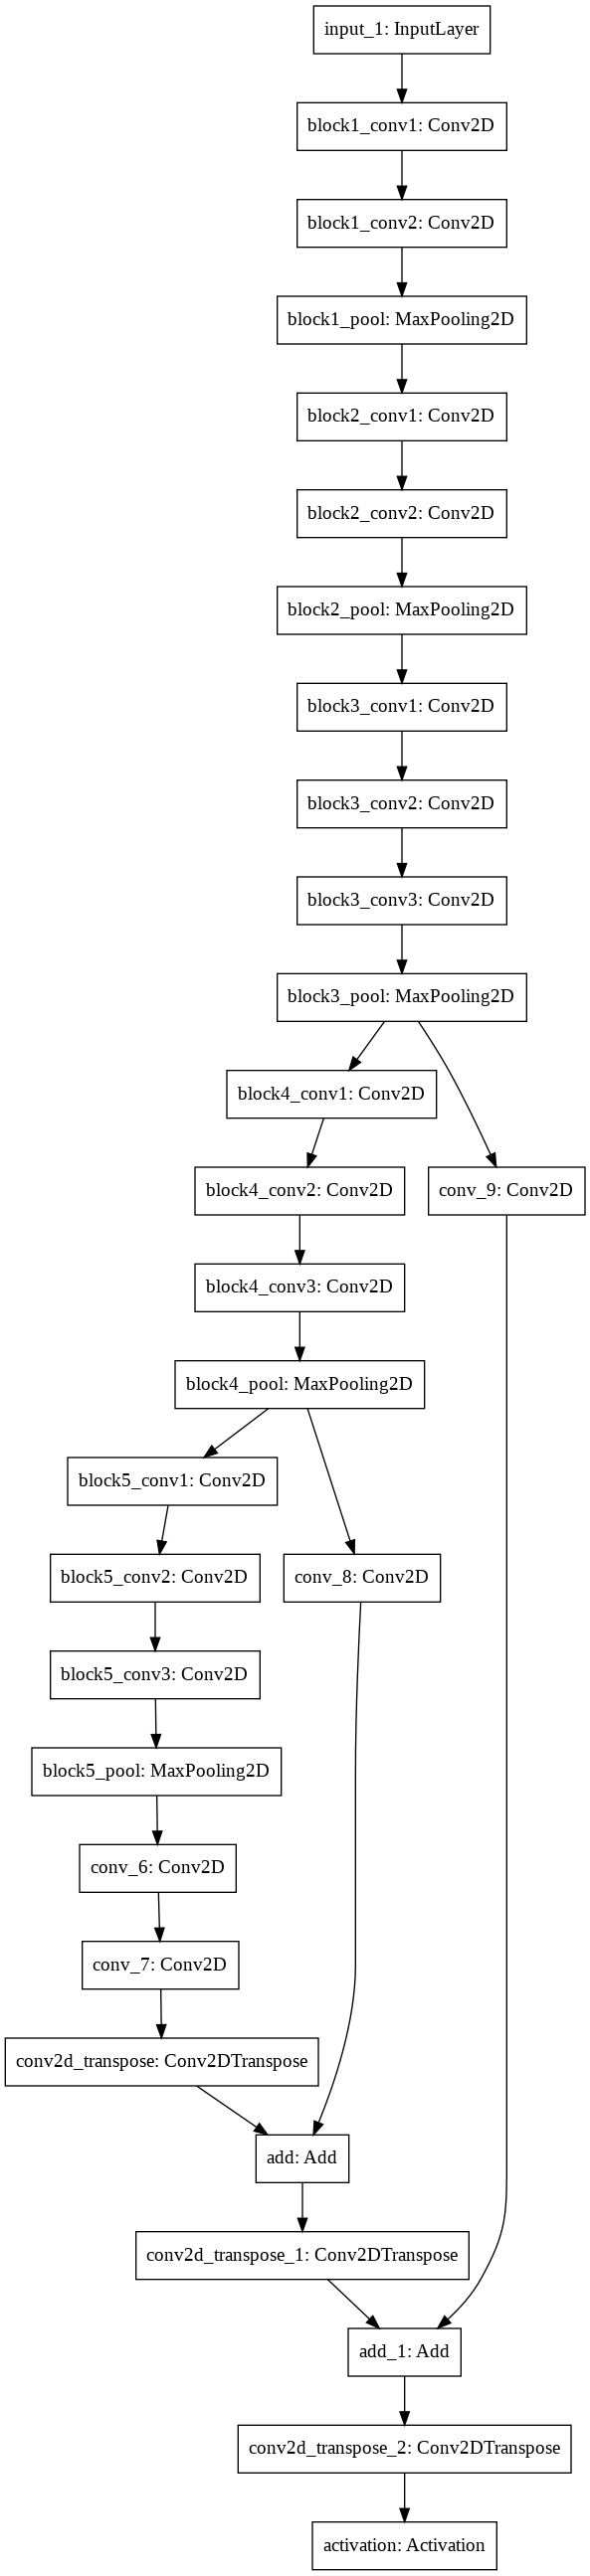

In [ ]:
plot_model(model)

In [ ]:
train_gen = DataGenerator()
val_gen = DataGenerator(valid_folder)

## **Training**

Trained for 20 epochs and use a Model Checkpoint to save the model with the smallest validation loss.

In [ ]:
## adam = Adam(lr=0.001, decay=1e-06)
## model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
## filepath = "VGG.h5"
## callbacks_list = [ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]

In [ ]:
## h = model.fit_generator(train_gen, epochs=20, steps_per_epoch=num_of_training_samples//batch_size,
##                        validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
##                        callbacks=callbacks_list, use_multiprocessing=True)

Save the model and load the best model from the training run.

In [ ]:
## model.save("VGG_model.h5")
## model = load_model("VGG_model.h5")

In [ ]:
## loss = h.history["val_loss"]
## acc = h.history["val_accuracy"] 
## 
## plot.figure(figsize=(12, 6))
## plot.subplot(211)
## plot.title("Val. Loss")
## plot.plot(loss)
## plot.xlabel("Epoch")
## plot.ylabel("Loss")
## 
## plot.subplot(212)
## plot.title("Val. Accuracy")
## plot.plot(acc)
## plot.xlabel("Epoch")
## plot.ylabel("Accuracy")
## 
## plot.tight_layout()
## plot.savefig("VGG_learn.png", dpi=150)
## plot.show()

##**The Results**

Visualizing how the model performs at the example of a few validation images

In [ ]:
model = load_model('VGG_model.h5')

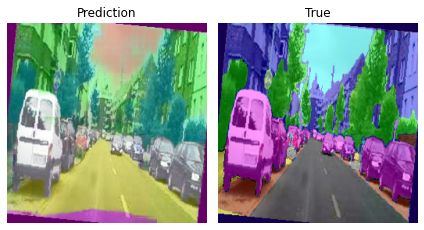

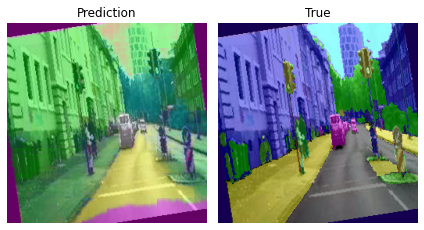

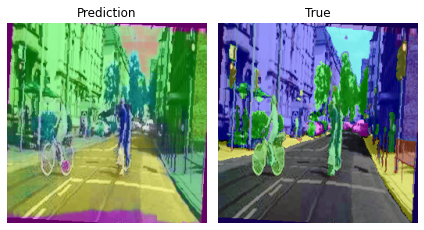

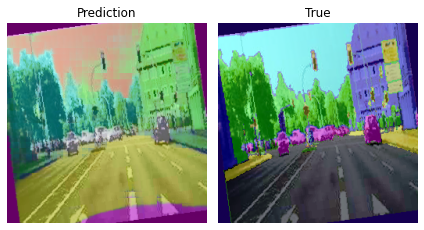

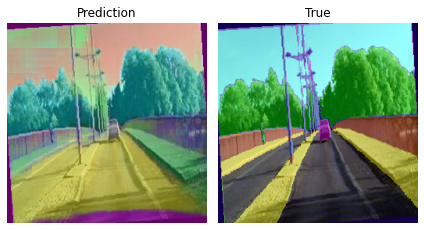

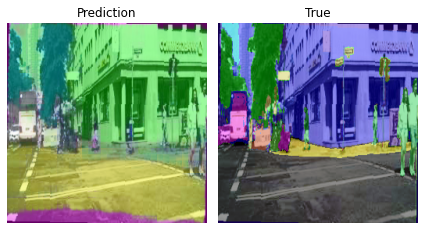

In [ ]:
test_gen = DataGenerator(valid_folder)
max_show=5
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(6,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

Plotting ROC_Curve for each class and calculating Balanced Accuracy

In [ ]:
from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = DataGenerator(valid_folder, batch_size=200)
max_show=20

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("VGG_BalAcc.png")
plot.show()

Calculating Mean IoU (Intersection over Union) using sklearn's `jaccard_similarity_score`

Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in `y_true`

In [ ]:
from sklearn.metrics import jaccard_similarity_score 

test_gen = DataGenerator(valid_folder, batch_size=200)

for imgs, segs in test_gen:
  p = model.predict(imgs)  
  IoU = []
  for i in range(p.shape[-1]):
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        iou = jaccard_similarity_score(segs[:,:,:,i].ravel(), _p)
        IoU.append(iou)
    
  break

plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(IoU)), IoU)
plot.xticks(np.arange(0, len(IoU)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("VGG_mIoU.png")
plot.show()